# Project: Identify Customer Segments

**Objectives**
- To identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I using is provided by Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA , FastICA
from sklearn.metrics import adjusted_rand_score , confusion_matrix , accuracy_score , classification_report
from sklearn.preprocessing import StandardScaler , Normalizer , LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier
# magic word for producing visualizations in notebook
%matplotlib inline


# Step 1#
# Loading DataSets#

There are four files associated with this project (not including this one):

- Udacity_AZDIAS_Subset.csv: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- Udacity_CUSTOMERS_Subset.csv: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- Data_Dictionary.md: Detailed information file about the features in the provided datasets.
- AZDIAS_Feature_Summary.csv: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, I load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv(r'D:\eLearning\Udacity\Intro to ML with pyTorch\Projects\Identify Customer Segments\Udacity_AZDIAS_Subset.csv' , sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv(r'D:\eLearning\Udacity\Intro to ML with pyTorch\Projects\Identify Customer Segments\AZDIAS_Feature_Summary.csv' , sep=';')

In [3]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [5]:
azdias.dtypes

AGER_TYP                  int64
ALTERSKATEGORIE_GROB      int64
ANREDE_KZ                 int64
CJT_GESAMTTYP           float64
FINANZ_MINIMALIST         int64
                         ...   
PLZ8_HHZ                float64
PLZ8_GBZ                float64
ARBEIT                  float64
ORTSGR_KLS9             float64
RELAT_AB                float64
Length: 85, dtype: object

In [6]:
azdias.shape

(891221, 85)

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_KAEM,person,ordinal,[-1]
freq,1,43,49,26


In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


# Step 2 - Preparing the Data / Data Cleansing#

# 2.1 Assessing Missing Data #

- The feature summary file contains a summary of properties for each demographics data column. 
- This file helps to make data cleansing decisions.

### Step 2.1.1: Convert Missing Value Codes to NaNs

The fourth column of the feature attributes summary (loaded in above as feat_info) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. [-1,0]), this will get read in as a string object.

- Now doing a little bit of parsing to make use of it to identify and clean the data. 
- Converting data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [10]:
# TOTAL missing values in azdias dataframe
azdias.isnull().sum().sum()

4896838

In [11]:
# Now remove strip [] from feat info dataframe
feat_info_2=feat_info.copy()
for index in range(85):
    missing_or_unknown = feat_info.iloc[index]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[' ']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(flag) if (flag!='X' and flag!='XX' and flag!='') else flag for flag in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[index]['attribute']: missing_or_unknown}, np.nan)

In [12]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
azdias.isnull().sum().sum()

8373929

**This task added more null values**

## Step 2.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? 
- There are a few columns that are outliers in terms of the proportion of values that are missing.
- Using matplotlib's hist() function to visualize the distribution of missing value counts to find these columns

In [14]:
missing_in_column=azdias.isnull().sum()
missing_in_column

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

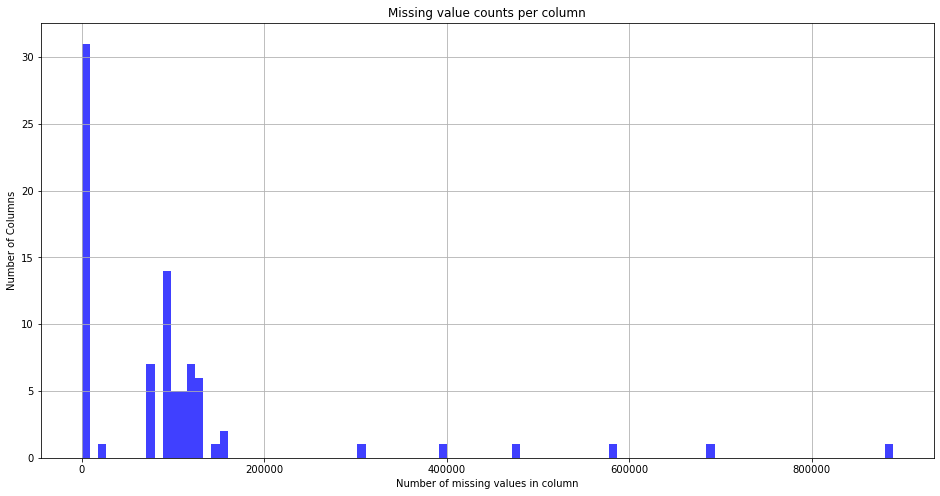

In [15]:
plt.figure(figsize=(16,8))
plt.hist(missing_in_column , bins=100 , alpha=0.75,  facecolor='Blue')
plt.ylabel('Number of Columns')
plt.xlabel('Number of missing values in column')
plt.grid(True)
plt.title('Missing value counts per column')
plt.show()

In [16]:
#Remove ouliers columns from dataset
#Outlier column in which number of missing values is greater than 150000
outlier_col=missing_in_column[missing_in_column > 150000]
outlier_col

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
KKK             158064
REGIOTYP        158064
dtype: int64

In [17]:
azdias_2 = azdias.drop(outlier_col.index , axis=1)
azdias_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [18]:
azdias_2.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


### Assessing Missing Values in Each Rows

In [19]:
# How much data is missing in each row of the dataset?
missing_in_row = azdias_2.isnull().sum(axis=1)

df_row_missing = pd.DataFrame(list(missing_in_row.values))
df_row_missing.columns =["count_row_missing"]

# sort df by Count column
df_row_missing = df_row_missing.sort_values(by=["count_row_missing"], ascending=False)

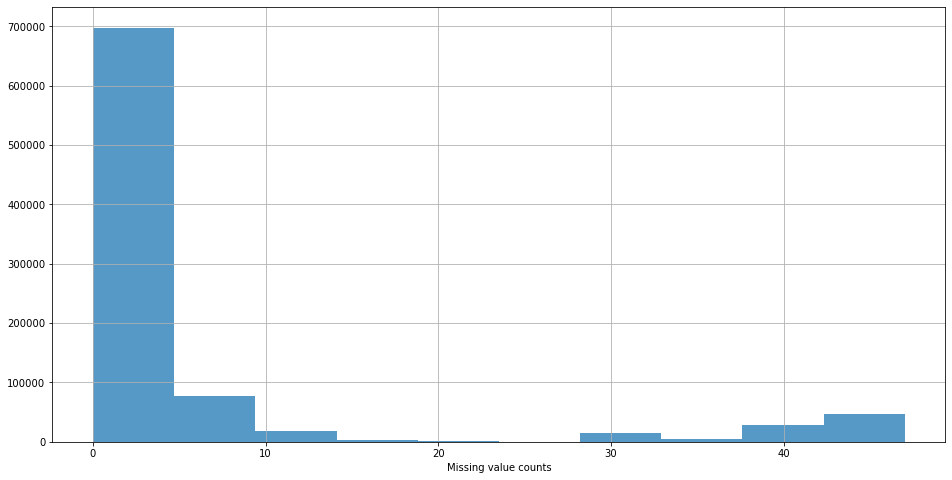

In [20]:
plt.figure(figsize=(16,8))
plt.hist(missing_in_row , bins=10 , alpha=0.75)
plt.grid(True)
plt.xlabel('Missing value counts')
plt.show()

In [21]:
azdias_mv_under_20 = azdias_2.drop(df_row_missing[df_row_missing["count_row_missing"] > 20].index)
azdias_mv_above_20= azdias_2.drop(df_row_missing[df_row_missing['count_row_missing'] < 20].index)

In [22]:
# azdias_mv_above_20 -> Rows which have more than 20 columns missing/NA
# azdias_mv_under_20 -> Rows which have less than 20 columns missing/NA
print(azdias_mv_under_20.shape)
print(azdias_mv_above_20.shape)

(797609, 77)
(93781, 77)


Now we can Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

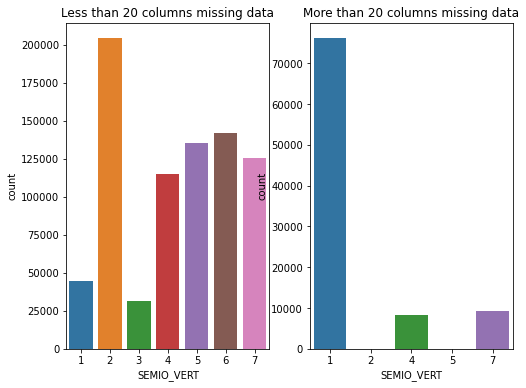

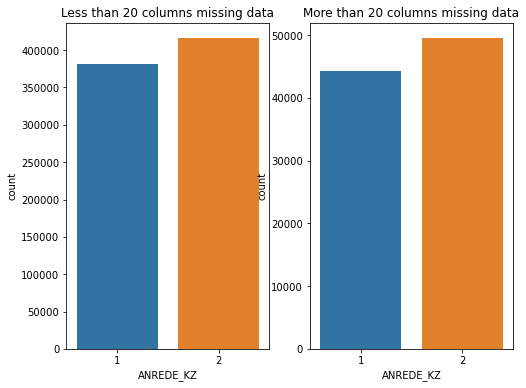

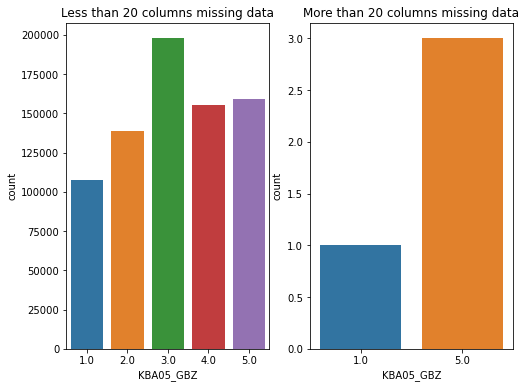

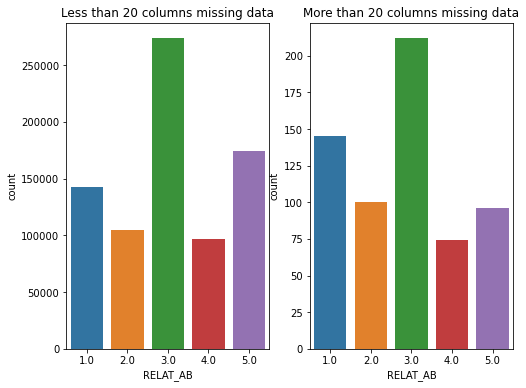

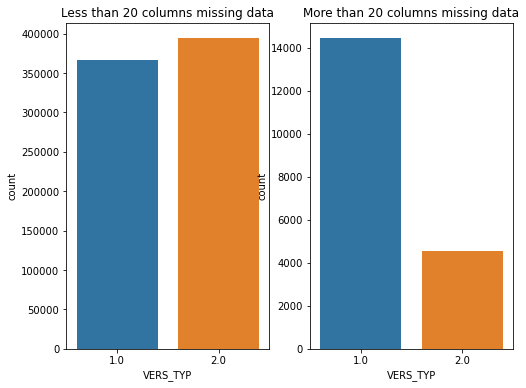

In [23]:
import random 
for i in random.sample(range(79), 5):
    plt.figure(figsize=(8,6))
    plt.subplot(1,2,1)
    sns.countplot(x = azdias_mv_under_20.columns[i], data = azdias_mv_under_20)
    plt.title('Less than 20 columns missing data')
    
    plt.subplot(1,2,2)
    sns.countplot(x = azdias_mv_above_20.columns[i], data = azdias_mv_above_20)
    plt.title('More than 20 columns missing data')

# Step 2.2: Select and Re-Encode Features

- Checking for missing data isn't the only way in which we can prepare a dataset for analysis. 
- Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, so we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 
- We will Check the third column of the feature summary (feat_info) for a summary of types of measurement.

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.**

Now performing an investigation of the categorical and mixed-type features and will make a decision on each of them, whether I  will keep, drop, or re-encode each.

In [24]:
azdias_clean = azdias_mv_under_20
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [25]:
cleaned_features = azdias_clean.columns.values
feat_info_clean = feat_info[feat_info['attribute'].isin(cleaned_features)]

In [26]:
# How many features are there of each data type?
count_types=feat_info_clean['type'].value_counts()
count_types

ordinal        47
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

- only 6 columns are of numerical  data, so we can kept them without change
- majority of data are ordinal and cateorical (65 out of 77 , 77 as other are dropped already(outliers))

### Now  Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we perform one of the following:

- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis.

**Assess categorical variables:** which are binary, which are multi-level, and which one needs to be re-encoded?**

In [27]:
categoricals = list(feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute'].values)
categoricals

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [28]:
azdias_categoricals = azdias_clean[categoricals].apply(lambda x: print(x.name, ':', x.unique()))

ANREDE_KZ : [2 1]
CJT_GESAMTTYP : [5.0 3.0 2.0 4.0 1.0 6.0 nan]
FINANZTYP : [1 6 5 2 4 3]
GFK_URLAUBERTYP : [10.0 1.0 5.0 12.0 9.0 3.0 8.0 11.0 4.0 2.0 7.0 6.0 nan]
GREEN_AVANTGARDE : [0 1]
LP_FAMILIE_FEIN : [5.0 1.0 nan 10.0 2.0 7.0 11.0 8.0 4.0 6.0 9.0 3.0]
LP_FAMILIE_GROB : [3.0 1.0 nan 5.0 2.0 4.0]
LP_STATUS_FEIN : [2.0 3.0 9.0 4.0 1.0 10.0 5.0 8.0 6.0 7.0 nan]
LP_STATUS_GROB : [1.0 2.0 4.0 5.0 3.0 nan]
NATIONALITAET_KZ : [1.0 3.0 2.0 nan]
SHOPPER_TYP : [3.0 2.0 1.0 0.0 nan]
SOHO_KZ : [1.0 0.0]
VERS_TYP : [2.0 1.0 nan]
ZABEOTYP : [5 3 4 1 6 2]
GEBAEUDETYP : [8.0 1.0 3.0 2.0 6.0 4.0 5.0]
OST_WEST_KZ : ['W' 'O']
CAMEO_DEUG_2015 : ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [29]:
multi_categorical = list()
binary_categorical = list()
for category in categoricals:
    if len(azdias_clean[category].value_counts()) > 2:
        multi_categorical.append(category)
    else:
        binary_categorical.append(category)

In [30]:
print("Multiple level categorical feature\n", multi_categorical)
print("\nTwo level categorical feature\n", binary_categorical)

Multiple level categorical feature
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Two level categorical feature
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [31]:
for c in binary_categorical:
    print(azdias_clean[c].value_counts())

2    415890
1    381719
Name: ANREDE_KZ, dtype: int64
0    622437
1    175172
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790895
1.0      6714
Name: SOHO_KZ, dtype: int64
2.0    394173
1.0    366938
Name: VERS_TYP, dtype: int64
W    629147
O    168462
Name: OST_WEST_KZ, dtype: int64


In [32]:
# Encode binary columns 
azdias_clean['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias_clean['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias_clean['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

In [33]:
for c in binary_categorical:
    print(azdias_clean[c].value_counts())

1    415890
0    381719
Name: ANREDE_KZ, dtype: int64
0    622437
1    175172
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790895
1.0      6714
Name: SOHO_KZ, dtype: int64
1.0    394173
0.0    366938
Name: VERS_TYP, dtype: int64
1    629147
0    168462
Name: OST_WEST_KZ, dtype: int64


In [34]:
#Re-encode categorical variable(s) to be kept in the analysis.
azdias_clean = pd.get_dummies(azdias_clean, columns=multi_categorical)
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


**I encoded the binary categorical features with values of 0 and 1. I used the pd.get_dummies method to encode the multi-level categorical features. No categorical features were dropped as processing them was simple and straightforward.**

## Step : Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention;

- **"PRAEGENDE_JUGENDJAHRE"** combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, so creating two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- **"CAMEO_INTL_2015"** combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [36]:
# Map generation 
gen_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

def map_gen(x):
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [37]:
# Create generation column
azdias_clean['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)

# Create movement column
azdias_clean['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


In [39]:
# Map wealth 
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

# Map life stage
def map_lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [40]:
# Create wealth column
azdias_clean['CAMEO_INTL_2015_wealth'] = azdias_clean['CAMEO_INTL_2015'].apply(map_wealth)

# Create life stage column
azdias_clean['CAMEO_INTL_2015_lifestage'] = azdias_clean['CAMEO_INTL_2015'].apply(map_lifestage)

In [41]:
azdias_clean = azdias_clean.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,5.0,0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,5.0,1,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,3.0,0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,3.0,0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1.0,0,5.0,4.0


### Step :: Complete Feature Selection

To summarize,I want that my  dataframe should consist of the following:

- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features

In [42]:
# Check that columns have the right type
np.unique(azdias_clean.dtypes.values)

array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

## Step :: Create a Cleaning Function

In [99]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index in range(85):
        missing_or_unknown = feat_info.iloc[index]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[' ']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(flag) if (flag!='X' and flag!='XX' and flag!='') else flag for flag in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[index]['attribute']: missing_or_unknown}, np.nan)
    
    # remove selected columns and rows, ...
    df = df.drop(outlier_col.index, axis=1)
    nan_rowcount = df.isnull().sum(axis=1)
    
    rows_many_missing = nan_rowcount[nan_rowcount > 20]
    
    df_many_missing = df.iloc[rows_many_missing.index]
    
    df = df[~df.index.isin(rows_many_missing.index)]
    # Encode binary columns 
    df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True) 
    #Re-encode categorical variable(s) to be kept in the analysis.
    df = pd.get_dummies(df, columns=multi_categorical)
    # select, re-encode, and engineer column values.
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)
    
    
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(map_wealth)
    df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(map_lifestage)
    
    df = df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    # Return the cleaned dataframe.
    return df , df_many_missing
    

# Step 3: Feature Transformation

## Step 3.1 : Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [44]:
azdias_3 = azdias_clean.copy()
# Imputing NaNs
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
azdias_4 = imputer.fit_transform(azdias_3)
df_azdias = pd.DataFrame(azdias_4, columns=azdias_clean.columns.values)

**Apply feature scaling to the general population demographics data.
- For the actual scaling function, a StandardScaler instance is suggested, scaling each feature to mean 0 and standard deviation 1.

In [45]:
scaler=StandardScaler()
azdias_5=scaler.fit_transform(df_azdias)
azdias_final = pd.DataFrame(azdias_5 , columns=df_azdias.columns.values)

The nan were imputed using the median value per column. The median was chosen, instead of the mean, because it is more robust against outliers. The features were standardized using StandardScaler to achieve a mean of 0 and standard deviation of 1

# Step 3.2:  Dimensionality Reduction

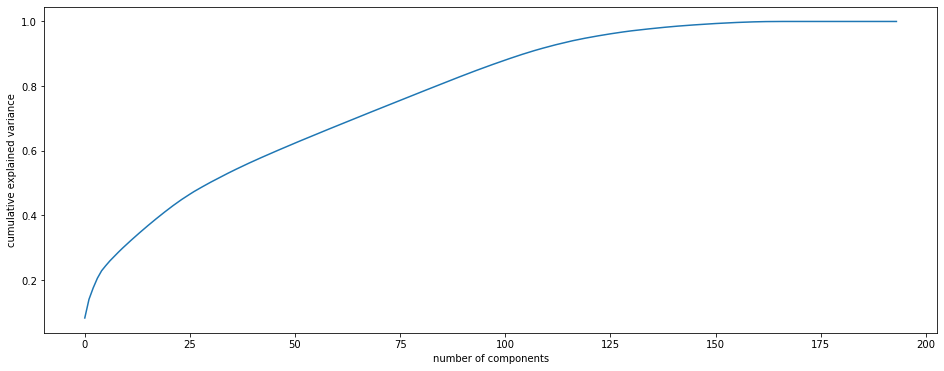

In [48]:
plt.figure(figsize=(16,6))
pca = PCA().fit(azdias_final)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [49]:
# Apply PCA to the data.
pca = PCA(150)
pca_features = pca.fit_transform(azdias_final)

In [50]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

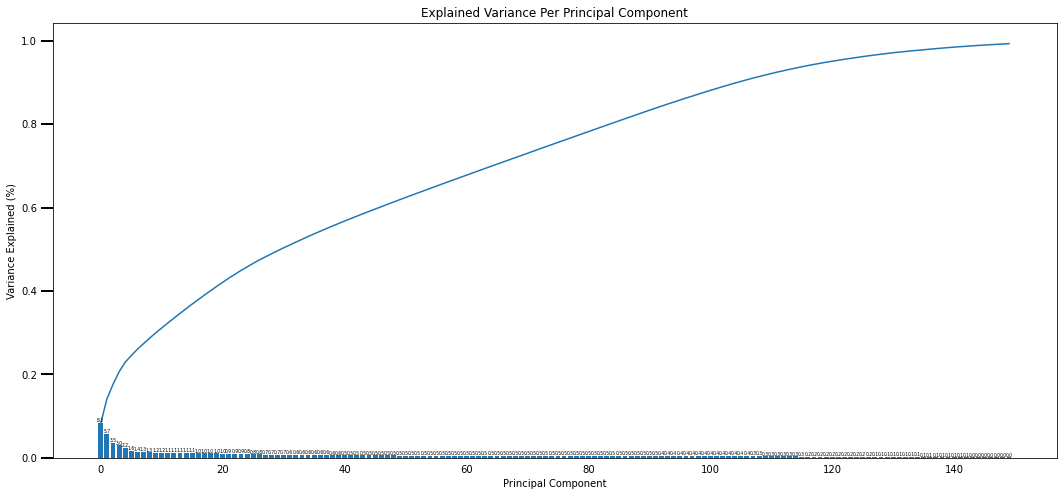

In [51]:
scree_plot(pca)

First of all, We use .plot() function to plot between explianed variance vs number of principal components required. And Found that to achieve around 95% variance explained we should use around 150 n_components.
So Dimensionality Reduction is done by 150 n_components

In [53]:
np.array(pca_features).shape

(797609, 150)

## Step 3.3: Interpret Principal Components

 each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [56]:
def plot_pca(data, pca, n_component):
    '''
	Plot the features with the most absolute variance for given pca component 
	'''
    compo_df = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_component-1]
    compo_df.sort_values(ascending=False, inplace=True)
    compo_df = pd.concat([compo_df.head(5), compo_df.tail(5)])
    
    compo_df.plot(kind='bar', title='Component ' + str(n_component))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.75)
    ax.set_axisbelow(True)
    plt.show()

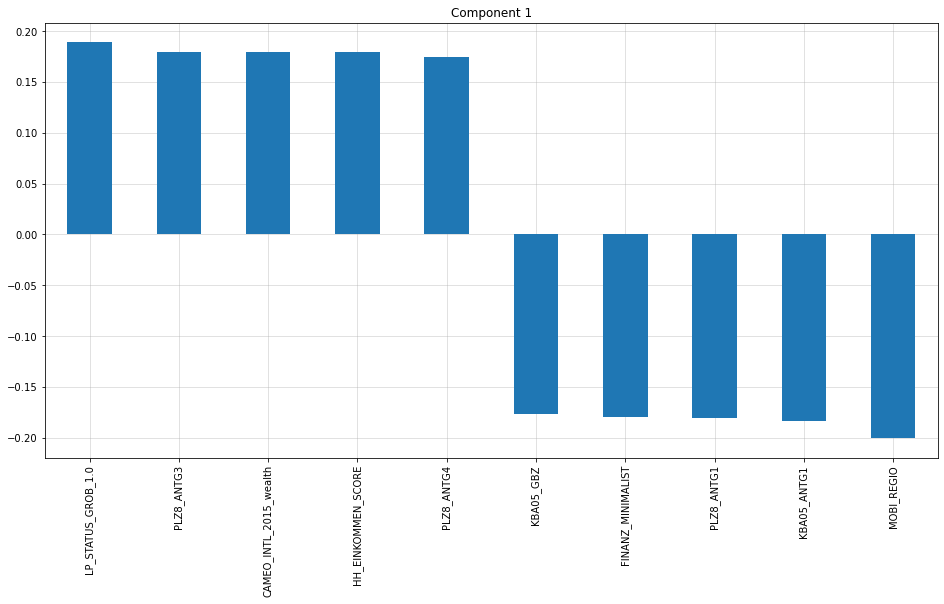

In [59]:
plt.figure(figsize=(16,8))
plot_pca(azdias_final , pca , 1)

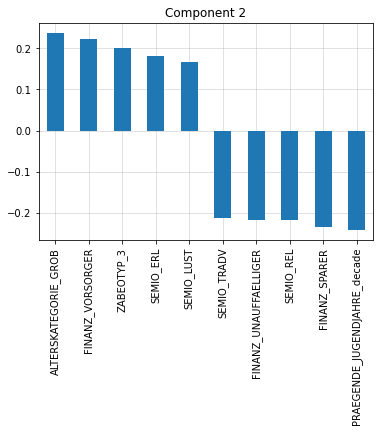

In [60]:
plot_pca(azdias_final , pca , 2)

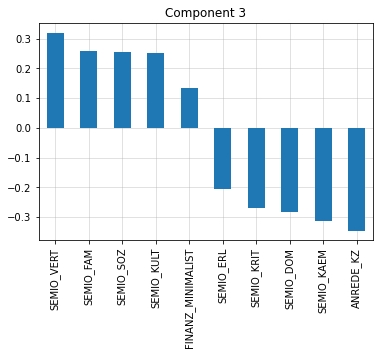

In [61]:
plot_pca(azdias_final , pca , 3)

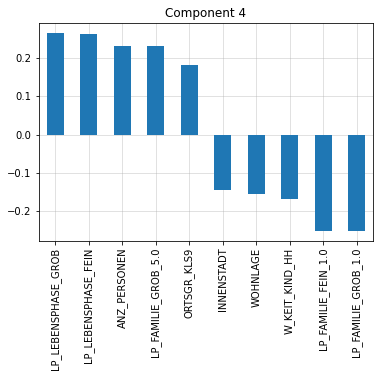

In [62]:
plot_pca(azdias_final , pca , 4)

In [63]:
print("The variance explained by the first component is {}%".format(pca.explained_variance_ratio_[0]*100))

The variance explained by the first component is 8.310316605010687%


In [64]:
print("The variance explained by the second component is {}%".format(pca.explained_variance_ratio_[1]*100))

The variance explained by the second component is 5.766064708171134%


In [65]:
print("The variance explained by the third component is {}%".format(pca.explained_variance_ratio_[2]*100))

The variance explained by the third component is 3.5268046178543635%


# Step 4: Clustering

In [67]:
azdias_final.shape

(797609, 194)

In [68]:
np.array(pca_features).shape

(797609, 150)

## Step 4.1: Apply Clustering to General Population

So far I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I am applying k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

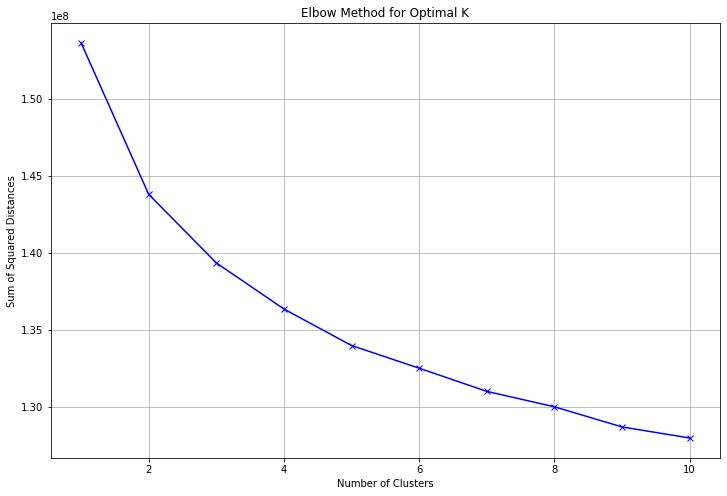

In [69]:
from sklearn.cluster import KMeans
# ssd - Sum of squared Distances from cluster center
ssd=[]
K=range(1,11)
for k in K:
    km=KMeans(n_clusters=k)
    km=km.fit(pca_features)
    ssd.append(km.inertia_)
plt.figure(figsize=(12,8))
plt.plot(K,ssd , 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

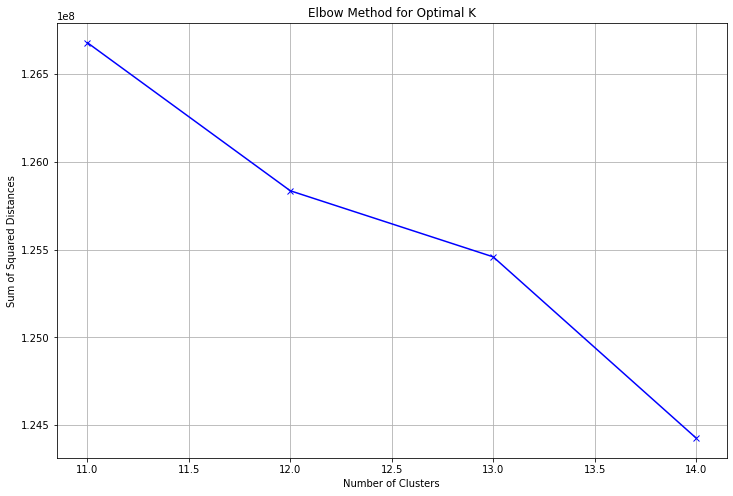

In [72]:
from sklearn.cluster import KMeans
# ssd - Sum of squared Distances from cluster center
ssd2=[]
K2=range(11,15)
for k in K2:
    km=KMeans(n_clusters=k)
    km=km.fit(pca_features)
    ssd2.append(km.inertia_)
plt.figure(figsize=(12,8))
plt.plot(K2,ssd2 , 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

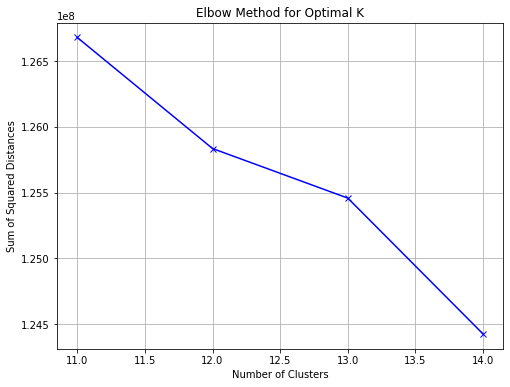

In [73]:
plt.figure(figsize=(8,6))
plt.plot(K,ssd2 , 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [163]:
# Re-applying PCA to the data while selecting for number of components to retain.
# n_clusters = 20
import time
ssd4=[]
start_time = time.time()
km=KMeans(n_clusters=20)
km=km.fit(pca_features)
km_labels = km.predict(pca_features)
ssd4.append(km.inertia_)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 3.25 mins ---


In [164]:
ssd4

[120043498.6987821]

# Step 4.2: Applying All Steps to the Customer Data

In [165]:
# Load in the customer demographics data.
customers = pd.read_csv(r'D:\eLearning\Udacity\Intro to ML with pyTorch\Projects\Identify Customer Segments\Udacity_CUSTOMERS_Subset.csv' , sep=';')

In [166]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [167]:
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


- Applying the same feature wrangling, selection, and engineering steps to the customer demographics using the clean_data() function created earlier.
- (Assuming that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)

In [168]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [169]:
customers_final, customers_many_missing  = clean_data(customers)

In [170]:
customers_final = pd.DataFrame(customers_final)

customers_final.describe()

In [171]:
# Imputing NaNs
customers_impute = imputer.fit_transform(customers_final)

In [172]:
#Standardization
customers_std=scaler.fit_transform(customers_impute)
cust_std=pd.DataFrame(customers_std , columns=customers_final.columns.values)

###### Dimensionality Reduction

Text(0, 0.5, 'cumulative explained variance')

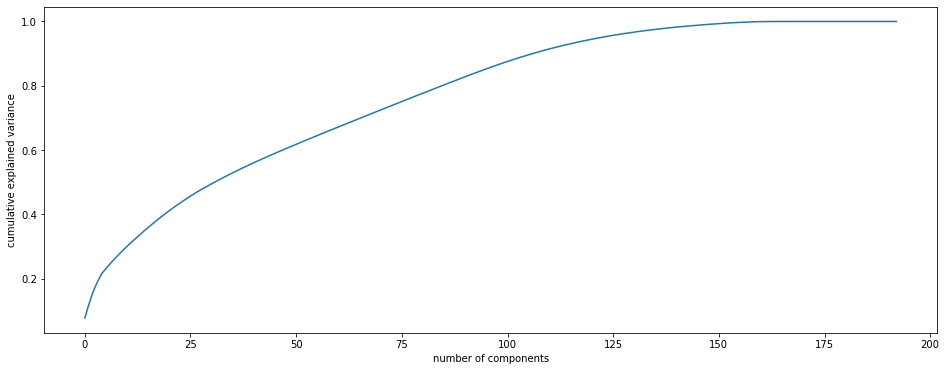

In [174]:
plt.figure(figsize=(16,6))
pca_cust = PCA().fit(cust_std)
plt.plot(np.cumsum(pca_cust.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [175]:
pca_customers = PCA(150).fit_transform(cust_std)

In [242]:
km2=KMeans(n_clusters=20)
km2=km2.fit(pca_customers)
km_customers = km2.predict(pca_customers)

In [243]:
x=pd.DataFrame(pca_customers)
x.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-3.323200,-3.964772,-0.194873,-1.405182,-1.785675,0.743749,2.067238,-0.696188,0.105189,2.500457,...,0.362831,-0.703531,-0.258804,0.285120,-0.624142,0.053952,-0.119699,0.418211,0.047943,-0.172238
1,3.663693,-2.658173,-2.431352,3.517192,-2.353480,0.596016,-0.092538,-1.473507,-0.399428,-2.490835,...,1.194999,-0.275944,-0.213232,0.703532,-0.065485,-0.525365,0.769813,0.641597,0.195462,-0.032628
2,-3.060208,0.118496,-2.418038,-4.989277,0.114900,0.344652,-0.196826,0.763297,-0.278116,-0.901203,...,-0.780110,0.526821,-0.477404,-0.150623,0.371540,0.007141,-0.165569,0.144699,0.102851,0.090865
3,2.961989,4.446180,3.345459,-0.499323,2.789313,-0.431819,-1.166202,-0.159283,-1.182150,-1.105351,...,-0.929003,-0.784908,0.202882,-0.278860,0.047568,-0.236204,0.552000,-0.492489,-0.510908,1.014301
4,0.217297,-1.229635,2.724335,0.676220,-1.995748,3.845675,-3.040178,-1.637001,2.645756,0.426251,...,-0.419397,0.457497,-0.062923,0.209495,-0.408282,0.191369,-0.074370,-0.354036,0.136346,-0.118983


# Step 4.3: Comparing Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this substep, will compare the two cluster distributions to see where the strongest customer base for the company is

In [244]:
from collections import Counter, OrderedDict

In [245]:
def generate_proportions(labels):
    """
    
    Arguments:
        labels: An array of labels after kmeans predict() method. 
    
    Returns: 
        proportions_dict: A sorted-by-key dictionary with labels as the keys and proportion of labels out of the total
                          as the values. 
    """
    labels_count = Counter(labels)
    total = len(labels)

    label_proportion = {key: values / total for key, values in labels_count.items()}
    label_proportion_ordered = OrderedDict(sorted(label_proportion.items(), key=lambda t: t[0]))
    
    return label_proportion_ordered

In [246]:
customer_proportion = generate_proportions(pd.DataFrame(km_customers))
customer_proportion

OrderedDict([(0, 7.059404892167591e-06)])

In [247]:
population_proportion = generate_proportions(km_labels)
population_proportion

OrderedDict([(0, 0.013754859837338847),
             (1, 0.08558830203771522),
             (2, 0.044340021238476496),
             (3, 0.050893357522294756),
             (4, 0.06600351801446573),
             (5, 0.04013119210039004),
             (6, 0.10183184994151269),
             (7, 0.005408665147960968),
             (8, 0.0716516488655469),
             (9, 0.053932440581788824),
             (10, 0.028634330856346906),
             (11, 0.05875435206974846),
             (12, 0.008069116572155028),
             (13, 0.09296409644324474),
             (14, 0.02896281260617671),
             (15, 0.013457721765927917),
             (16, 0.04945907079784707),
             (17, 0.09533117103743814),
             (18, 0.005101497099455999),
             (19, 0.08572997546416854)])

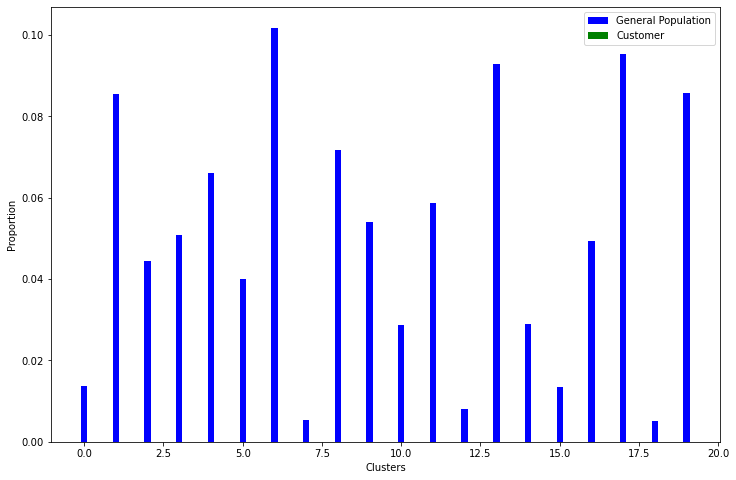

In [250]:
plt.figure(figsize=(12,8))
x=np.array(list(customer_proportion.keys()))
y=np.array(list(population_proportion.keys()))
customer = list(customer_proportion.values())
population = list(population_proportion.values())
ax = plt.subplot(111)
ax.bar(y, population,width=0.2, color = 'b', align = 'center', label = "General Population")
ax.bar(x, customer,width=0.2, color = 'g', align = 'center', label = "Customer")
x+=1
plt.xlabel("Clusters")
#plt.xticks(np.arange(len(x))+0.1, x)
plt.ylabel("Proportion")
plt.legend()

In [251]:
azdias_many_missing_array = np.full((azdias_mv_above_20.shape[0],), -1)
kmeans_all_labels = np.concatenate((km_labels, azdias_many_missing_array))

In [253]:
customers_many_missing_array = np.full((customers_many_missing.shape[0],), -1)
kmeans_all_customers = np.concatenate((km_customers,customers_many_missing_array ))

In [254]:
# proportion of data in each cluster for the general population.

# Proportions for general data
dict_data = {'proportion': pd.Series(kmeans_all_labels).value_counts(normalize=True, sort=False), 
          'source': 'general'}

general_proportions = pd.DataFrame(dict_data)

# Proportions for customer data
dict_data = {'proportion': pd.Series(kmeans_all_customers).value_counts(normalize=True, sort=False), 
          'source': 'customer'}

customer_proportions = pd.DataFrame(dict_data)

# Concatenate proportions
total_proportions = pd.concat([general_proportions, customer_proportions])

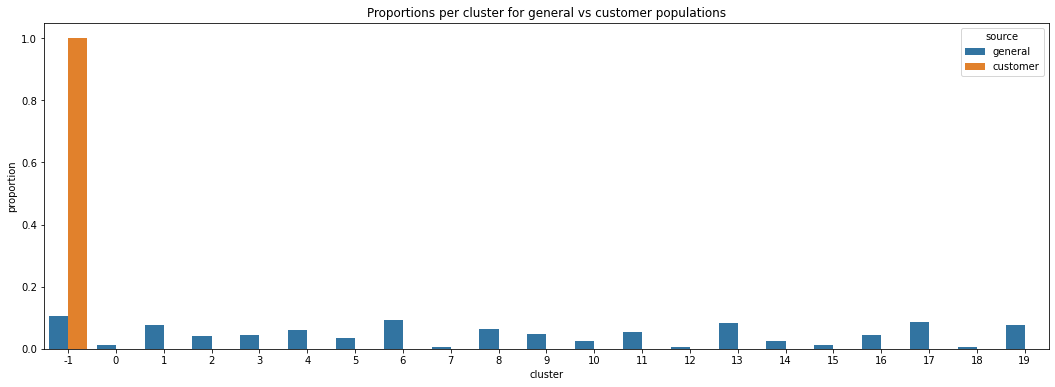

In [256]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(ax=ax, x=total_proportions.index, y = total_proportions.proportion, hue=total_proportions.source)
ax.set_xlabel('cluster')
ax.set_title('Proportions per cluster for general vs customer populations');

In [257]:
# Check difference in cluster proportion for general vs customer populations
diff_customer_proportions = customer_proportions['proportion'] - general_proportions['proportion']
diff_customer_proportions.sort_values(ascending=False, inplace=True)
print('over-represented')
print(diff_customer_proportions[:3])
print('\nunder-represented')
print(diff_customer_proportions[-3:])

over-represented
-1     0.894772
 10   -0.025602
 0          NaN
Name: proportion, dtype: float64

under-represented
17   NaN
18   NaN
19   NaN
Name: proportion, dtype: float64
